<a href="https://colab.research.google.com/github/Lova595/Neural-networks/blob/main/%D0%9D%D0%A1_%D0%BF%D0%BE_%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8E_%D0%BC%D0%B8%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Повысьте точность модели по обнаружению мин до 90 % на тестовой выборке.

Можно использовать различные варианты слоев Dropout и BatchNormalization. Можно менять количество примеров в обучающей и проверочной выборках, но нельзя менять количество примеров в тестовой.


---



P.S.удалось добиться точности 90% в последнем эксперименте



**Это нейросеть с использованием полносвязной сверточной сети (CNN) для классификации признаков**

---

Мы имеем датасет с данными эхолота по обноружению мин и хотим обучить модель классифицировать их на два класса: 0 и 1.

Для начала, мы должны преобразовать наши данные в числовой формат. Все числовые данные с 0 по 60-й столбик преобразуем в числовые значения типа float, это наши примеры, а буквенные значения 'R' и 'M' в '0' и '1', соответственно, это наши правильные ответы о не обнаруженных или обнаруженных минах.

Далее, добавим данные в обучающую (x_train, y_train) и тестовую (x_test, y_test) выборки (это test_size=0.2, то есть 20% от всех данных), а так же, проверочную выборку (validation_split=0.2 - это 20% от обучающих данных).

Затем мы построим несколько CNN со сверточными слоями, слоями дропаута (для отключения части нейронов), слоями батч нормализации и проведем серию экспериментов. Каждый сверточный слой будет применять набор фильтров к каждой части данных и выдавать карты признаков. Мы используем эти карты признаков для извлечения более абстрактных признаков из числовых данных.

В конце мы добавляем полносвязный слой на выходе с одним нейроном, который будет принимать карты признаков и выдавать вероятности для каждого класса в качестве предсказания. Так как наша задача на бинарную классификацию, то используем активационную функцию sigmoid.

В процессе обучения, модель будет минимизировать функцию потерь (кросс-энтропия) между предсказанными и фактическими вероятностями.

В результате, мы используем обученную модель для обнаружения мин. Модель будет принимать на вход данные эхолота и определять есть или нет мины.

# Нейросеть по обнаружению мин

In [1]:
# @title Подключаем библиотеки

from tensorflow.keras.models import Sequential # нс прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # утилиты для to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta # алгоритмы оптимизации для насторойки скорости обучения
import numpy as np # библиотека работы с массивами
import pandas as pd # библиотека для обработки и анализа  данных
import matplotlib.pyplot as plt # отрисовка изображений
from PIL import Image
from google.colab import files # импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # функции для нормализации данных
from sklearn import preprocessing # пакет предварительной обработки данных
from sklearn.model_selection import train_test_split # функция разделения на обучающую и проверочную/тестовую выборку
# Отрисовывать изображеня в ноутбуке а не в консоли или файл
%matplotlib inline

In [2]:
# @title Загружаем данные
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# загружаем данные из файла sonar.csv (файл сохранен по ссылке на googledrive в формате zip-файла и распакован с помощью ZipExtractor от google)
df = pd.read_csv('/content/drive/MyDrive/base_l2.zip (Unzipped Files)/sonar.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [12]:
print(df.shape) # размерность данных

(208, 61)


In [4]:
# @title Нормализуем данные
dataset = df.values # берем только значения массива(без индексов)
X = dataset[:,0:60].astype(float) # Присваиваем им тип данных - float(с плавающей точкой) данным с 0 по 60 колонки
Y = dataset[:,60] # Присваеваем значению Y данные из столбца с индексом 60
Y[Y=='R']='0' # если значение элемента столбца равняется R, присваиваем ему 1
Y[Y=='M']='1' # если значение элемента  столбца равняется M, присваиваем ему 0
Y = Y.astype(int) # меняем тип данных столбца на int
# выводим размерности
print(X.shape)
print(Y.shape)
print(Y)

(208, 60)
(208,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [6]:
# @title Делим данные на обучающую и проверочную выборку
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True) # с помощью функции делим датасет на тренировочную и тестовую выборки в соотношении 80/20, используем shuffle для перемешивания данных

# проверим полученные размеры
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(166, 60)
(166,)
(42, 60)
(42,)


# Тестирование сетей

In [7]:
# @title Содаем НС
model = Sequential()

# добавляем слои
model.add(Dense(100, input_dim=60, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(520, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

# компилируем сеть
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# обучаем сеть
history = model.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1) # Выводить процесс обучения на каждой эпохе

Epoch 1/100
17/17 [==============================] - 2s 22ms/step - loss: 0.6888 - accuracy: 0.5606 - val_loss: 0.6976 - val_accuracy: 0.4706
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.5006 - accuracy: 0.7652 - val_loss: 0.7052 - val_accuracy: 0.4706
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.4117 - accuracy: 0.7879 - val_loss: 0.7113 - val_accuracy: 0.5000
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.4491 - accuracy: 0.7727 - val_loss: 0.7034 - val_accuracy: 0.5294
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3756 - accuracy: 0.8258 - val_loss: 0.6957 - val_accuracy: 0.5294
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.3079 - accuracy: 0.8712 - val_loss: 0.6927 - val_accuracy: 0.5588
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2696 - accuracy: 0.8712 - val_loss: 0.6818 - val_accuracy: 0.5882
Epoch 8/100


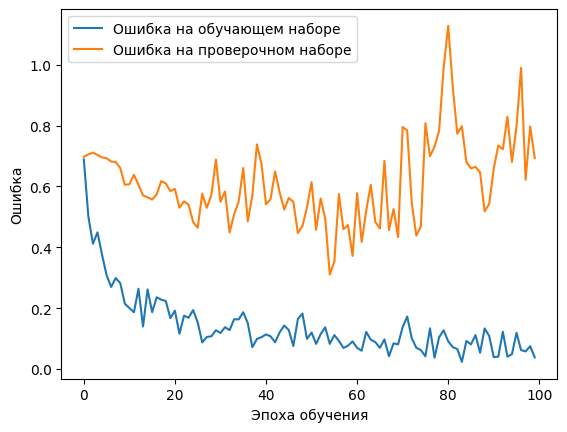

In [8]:
# @title Выводим графики
# графики ошибки
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [10]:
# @title Проверяем качество обучения на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)
print(scores)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке

print('Доля верных ответов на тестовых данных, в проценах ', round(scores[1] * 100, 4), "%", sep="")

2/2 [==============================] - 0s 8ms/step - loss: 0.6739 - accuracy: 0.7857
[0.6739324331283569, 0.7857142686843872]
Доля верных ответов на тестовых данных, в проценах 78.5714%


In [11]:
# @title Создаем сеть №2
model_2 = Sequential()

# Добавляем слои
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2, input_dim=60))
model_2.add(Dense(520, activation='relu'))
model_2.add(Dense(30,  activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# Компилируем сеть
model_2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Обучаем сеть
history_2 = model_2.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=100,
                    validation_split=0.2, # Указываем 20% случайных примеров для проверочной выборки
                    verbose=1) # Выводить процесс обучения на каждой эпохе

Epoch 1/100
17/17 [==============================] - 1s 16ms/step - loss: 0.5846 - accuracy: 0.6667 - val_loss: 0.7369 - val_accuracy: 0.4706
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3712 - accuracy: 0.8333 - val_loss: 0.7534 - val_accuracy: 0.5000
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3503 - accuracy: 0.8561 - val_loss: 0.8287 - val_accuracy: 0.4706
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.3408 - accuracy: 0.8182 - val_loss: 0.7697 - val_accuracy: 0.5000
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.2751 - accuracy: 0.9015 - val_loss: 0.7272 - val_accuracy: 0.5882
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2779 - accuracy: 0.8864 - val_loss: 0.7314 - val_accuracy: 0.5294
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3219 - accuracy: 0.8636 - val_loss: 0.7313 - val_accuracy: 0.5588
Epoch 8/100


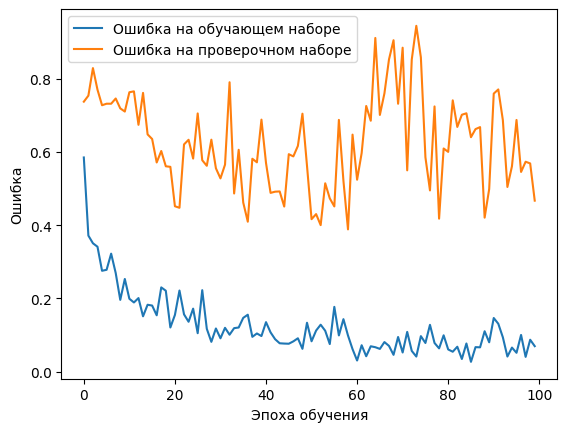

In [14]:
# @title Выводим графики модели 2
# графики ошибки
plt.plot(history_2.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history_2.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [15]:
# @title Проверяем качество обучения модели 2 на тестовом наборе данных
scores_2 = model_2.evaluate(x_test, y_test, verbose=1)
print(scores_2)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке

print('Доля верных ответов на тестовых данных, в проценах ', round(scores_2[1] * 100, 4), "%", sep="")

2/2 [==============================] - 0s 8ms/step - loss: 0.3863 - accuracy: 0.8333
[0.386275976896286, 0.8333333134651184]
Доля верных ответов на тестовых данных, в проценах 83.3333%


In [46]:
# @title Создаем сеть №3
model_3 = Sequential()

# Добавляем слои
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2, input_dim=60))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.3))
model_3.add(Dense(256,  activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

# Компилируем сеть
model_3.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# Обучаем сеть
history_3 = model_3.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=80,
                    validation_split=0.1, # Указываем 10% случайных примеров для проверочной выборки
                    verbose=1) # Выводить процесс обучения на каждой эпохе

Epoch 1/80
19/19 [==============================] - 2s 29ms/step - loss: 0.5921 - accuracy: 0.6443 - val_loss: 0.7331 - val_accuracy: 0.5294
Epoch 2/80
19/19 [==============================] - 0s 12ms/step - loss: 0.4284 - accuracy: 0.7919 - val_loss: 0.7167 - val_accuracy: 0.4118
Epoch 3/80
19/19 [==============================] - 0s 12ms/step - loss: 0.3758 - accuracy: 0.8456 - val_loss: 0.7009 - val_accuracy: 0.5294
Epoch 4/80
19/19 [==============================] - 0s 11ms/step - loss: 0.3476 - accuracy: 0.8322 - val_loss: 0.7279 - val_accuracy: 0.4706
Epoch 5/80
19/19 [==============================] - 0s 13ms/step - loss: 0.3477 - accuracy: 0.8658 - val_loss: 0.7339 - val_accuracy: 0.5294
Epoch 6/80
19/19 [==============================] - 0s 12ms/step - loss: 0.2971 - accuracy: 0.8792 - val_loss: 0.7552 - val_accuracy: 0.4706
Epoch 7/80
19/19 [==============================] - 0s 11ms/step - loss: 0.2783 - accuracy: 0.8792 - val_loss: 0.7412 - val_accuracy: 0.4706
Epoch 8/80
19

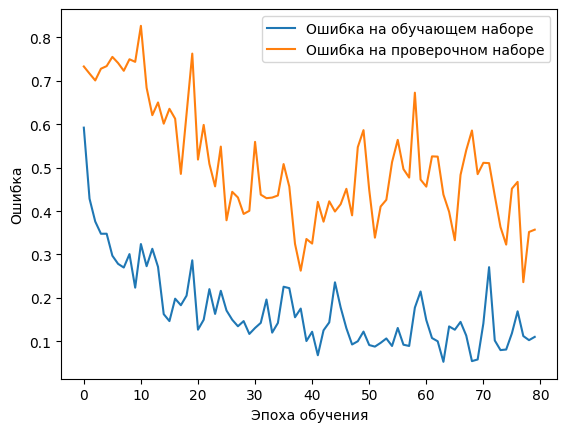

In [47]:
# @title Выводим графики модели 3
# графики ошибки
plt.plot(history_3.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history_3.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [48]:
# @title Проверяем качество обучения модели 3 на тестовом наборе данных
scores_3 = model_3.evaluate(x_test, y_test, verbose=1)
print(scores_3)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке

print('Доля верных ответов на тестовых данных, в проценах ', round(scores_3[1] * 100, 4), "%", sep="")

2/2 [==============================] - 0s 8ms/step - loss: 0.2960 - accuracy: 0.9048
[0.2960011065006256, 0.9047619104385376]
Доля верных ответов на тестовых данных, в проценах 90.4762%
